# Cryptocurrency Fundamental Data Analysis
### Author: GSR


## Introduction
We believe that future Bitcoin (BTC) market prices and volatility can be predicted by using a variety of fundamental data, sourced from the blockchain itself. In addition to that, we believe using altcoin data (ETH, LTC) the prediction signal can be enhanced.

In [2]:
# Run this each time our notebook has been reloaded
%matplotlib notebook

from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *

import base64
import os
import sys
import zipfile

import talib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykalman as kf
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import sklearn
import requests
import quandl
import time

from scipy.stats import jarque_bera
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller

sns.set()

qb = QuantBook()

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    # Copied from quantopian's multiple linear regressions lecture
    
    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            
            # Test the set
            result = sm.OLS(response, tmp, missing='drop').fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(response, selected).fit()
    return model

def check_adfuller(df, p_value=0.05):
    print('Time series has unit root' if adfuller(df)[1] < p_value else '')
    
def rolling_window_insample_optimizer(df, Y, window_lower_bound=0, window_top_bound=30, lags=0):
    pass

In [4]:
# Constants
RESOLUTION = Resolution.Daily
START = datetime(2017,2,10)
END = datetime(2017,12,31)

In [5]:
Q_DATA_BUNDLES = {
    'BCHAIN/TRFUS': None, # Bitcoin Total Transaction Fees USD
    'BCHAIN/AVBLS': None, # Average Block Size
    'BCHAIN/NADDU': None, # Number of Unique Bitcoin Addresses Used
    'BCHAIN/NTRBL': None, # Number of Transactions Per Block
    'BCHAIN/NTREP': None, # Number of Transactions Excluding Popular Addresses
    'BCHAIN/NTRAN': None, # Number of Transactions
    #'BCHAIN/TOTBC': None, # Total Bitcoins
}

decode_iterations = 12
quandl_api_key = b'' # Remove before public release
for i in range(decode_iterations):
    quandl_api_key = base64.b64decode(quandl_api_key)
    
quandl_data = quandl.get(
    list(Q_DATA_BUNDLES.keys()),
    api_key=quandl_api_key.decode('utf-8'),
    start_date=str(START.date()),
    end_date=str(END.date())
)
quandl_data.columns = Q_DATA_BUNDLES.keys()
quandl_data['POPTRANS'] = quandl_data['BCHAIN/NTRAN'] - quandl_data['BCHAIN/NTREP']

crypto_assets = map(qb.AddCrypto, ['BTCUSD', 'ETHUSD', 'LTCUSD'])
crypto_symbols = [asset.Symbol for asset in crypto_assets]

history = qb.History(qb.Securities.Keys, START - timedelta(days=1), END, RESOLUTION).unstack(level=0)

In [6]:
high_change = (history['close'] - history['high']) / history['high']
low_change = (history['close'] - history['low']) / history['low']

intraday_change = high_change + low_change

In [7]:
percentile = 0.90
percentile_df = intraday_change[intraday_change > intraday_change.quantile(percentile)]

forward_lookahead = 3
forward_period_change = {}

for entry in percentile_df.iterrows():
    timestamp = entry[0]
    timestamp_str = str(timestamp)
    data = entry[1]
    
    for asset in history.columns.levels[1]:
        point = data[asset]
        
        #print(point)
        if timestamp_str not in forward_period_change.keys():
            forward_period_change[timestamp_str] = {k:[] for k in history.columns.levels[1]}
            
        if not (point >= 0 or point < 0):
            forward_period_change[timestamp_str][asset] = np.nan
            continue
        
        forward_period_change[timestamp_str][asset] = history['close'][asset].loc[
            timestamp+timedelta(days=1): timestamp + timedelta(days=forward_lookahead)
        ].pct_change().cumsum().iloc[-1]

In [8]:
forward_pct_change = pd.DataFrame(forward_period_change).T.dropna(how='all')

<IPython.core.display.Javascript object>


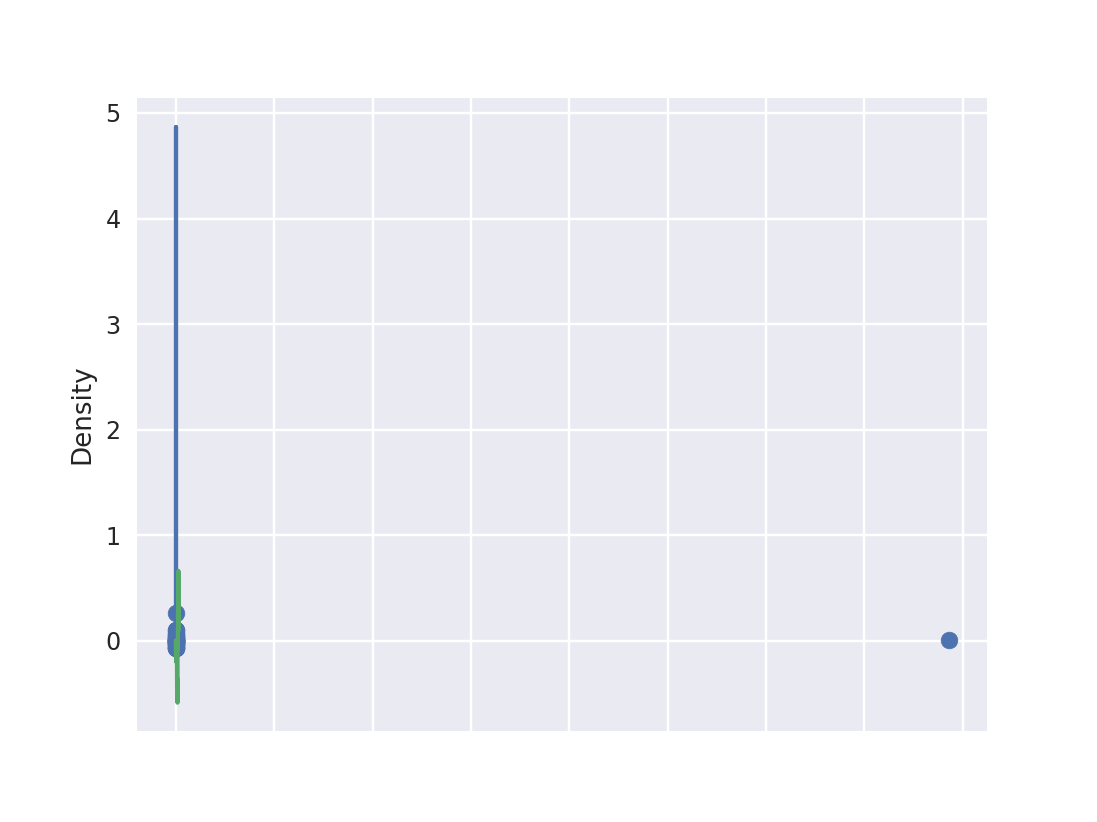

In [9]:
forward_pct_change['BTCUSD'].plot.kde()

In [10]:
plt.scatter(percentile_df['BTCUSD'].shift(forward_lookahead), history['close']['BTCUSD'].pct_change())

<IPython.core.display.Javascript object>


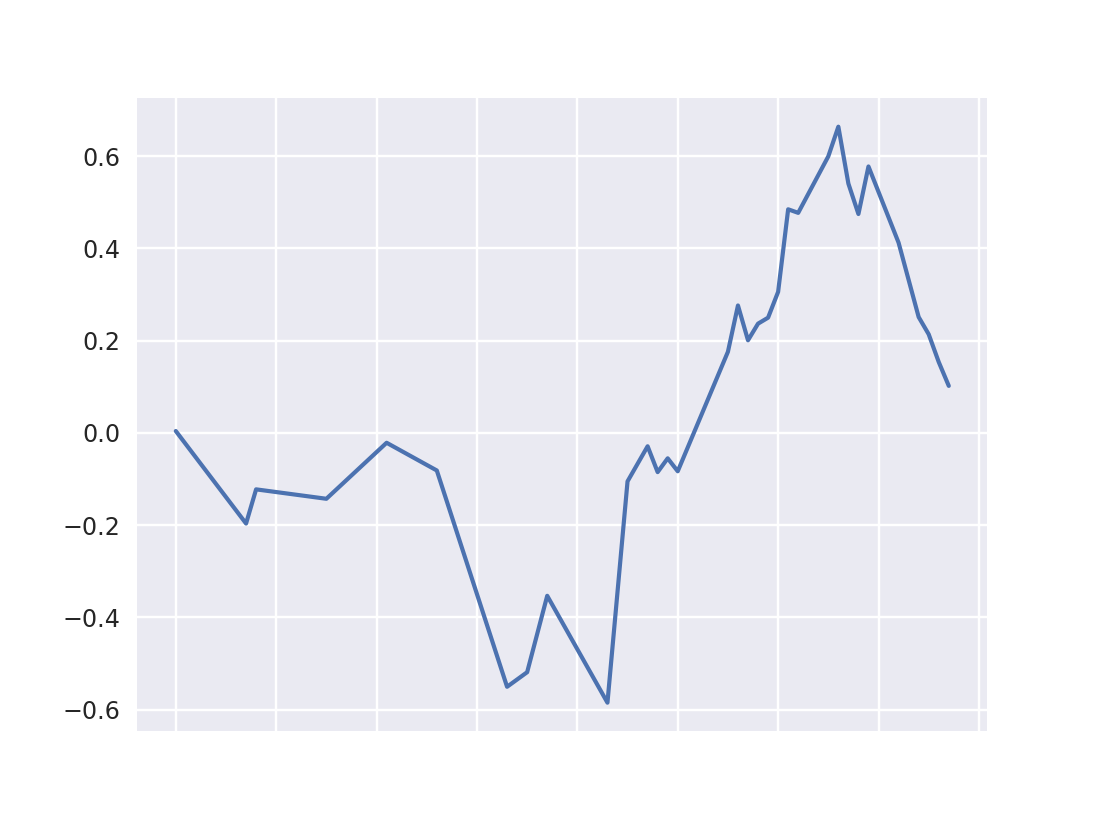

In [12]:
forward_pct_change.BTCUSD.fillna(method='ffill').cumsum().plot()